In [1]:
from grid_feedback_optimizer.models.loader import load_network_from_excel
from grid_feedback_optimizer.engine.powerflow import PowerFlowSolver
from grid_feedback_optimizer.engine.grad_proj_optimizer import GradientProjectionOptimizer
from grid_feedback_optimizer.engine.primal_dual_optimizer import PrimalDualOptimizer
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from power_grid_model import ComponentType
from grid_feedback_optimizer.models.solve_data import OptimizationInputs
from tqdm import tqdm

In [2]:
# Path to the example EXCEL in your project
network = load_network_from_excel("../examples/lv_97bus.xlsx")
n_transformer = len(network.transformers)
n_line = len(network.lines)
n_bus = len(network.buses)
n_load = len(network.loads)
n_gen = len(network.renew_gens)

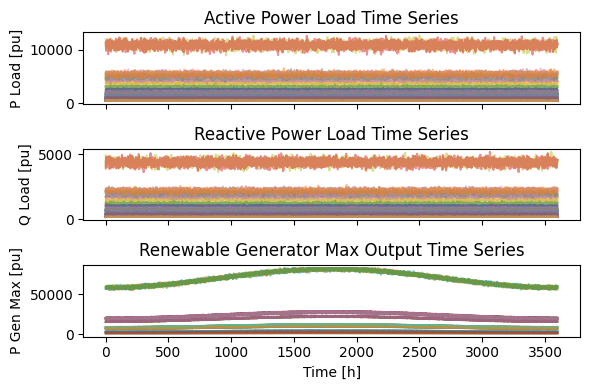

In [3]:
# simulate time series profiles
p_load = np.array([l.p_norm for l in network.loads])
q_load = np.array([l.q_norm for l in network.loads])
p_gen_max = np.array([g.p_max for g in network.renew_gens])

# Simulation parameters
n_steps = 3600  # 1 hour simulation, per second controller updates setpoints
time = np.arange(n_steps)

# Generate daily profiles (simple sinusoidal patterns)
daily_profile_load = np.ones(n_steps)
daily_profile_gen = 1.2 + 0.2 * np.sin(2*np.pi*time/3600 - np.pi/2)  # can tweak differently

# Generate time series
p_load_ts = np.outer(p_load, daily_profile_load)
q_load_ts = np.outer(q_load, daily_profile_load)
p_gen_ts = np.outer(p_gen_max, daily_profile_gen)

# Optional: add small random noise
p_load_ts += 0.05 * p_load[:, None] * np.random.randn(n_load, n_steps)
q_load_ts += 0.05 * q_load[:, None] * np.random.randn(n_load, n_steps)
p_gen_ts += 0.02 * p_gen_max[:, None] * np.random.randn(n_gen, n_steps)

# Ensure no negative values
p_load_ts = np.maximum(p_load_ts, 0)
q_load_ts = np.maximum(q_load_ts, 0)
p_gen_ts = np.maximum(p_gen_ts, 0)

# Ensure gen_max does not exceed inverter capacity
p_gen_ts = np.minimum(p_gen_ts, np.array([gen.s_inv for gen in network.renew_gens])[:, np.newaxis])

# Visualization
fig, axs = plt.subplots(3, 1, figsize=(6,4), sharex=True)

for ts in p_load_ts:
    axs[0].plot(time, ts, alpha=0.5)
axs[0].set_ylabel('P Load [pu]')
axs[0].set_title('Active Power Load Time Series')

for ts in q_load_ts:
    axs[1].plot(time, ts, alpha=0.5)
axs[1].set_ylabel('Q Load [pu]')
axs[1].set_title('Reactive Power Load Time Series')

for ts in p_gen_ts:
    axs[2].plot(time, ts, alpha=0.5)
axs[2].set_ylabel('P Gen Max [pu]')
axs[2].set_xlabel('Time [h]')
axs[2].set_title('Renewable Generator Max Output Time Series')

plt.tight_layout()
plt.show()
plt.close()

In [4]:
# load modules
power_flow_solver = PowerFlowSolver(network)
sensitivities = power_flow_solver.obtain_sensitivity(loading_meas_side = "to")
optimizer = PrimalDualOptimizer(network, sensitivities, alpha=0.3, alpha_t=20.0) 

In [5]:
# time series simulation: assuming the controller is updated per second
mat_p = np.zeros((n_gen, n_steps))
mat_q = np.zeros((n_gen, n_steps))
mat_v = np.zeros((n_bus, n_steps))
mat_line = np.zeros((n_line, n_steps))
if n_transformer >= 1:
    mat_transformer = np.zeros((n_transformer, n_steps))

# iterating process
for k in tqdm(time):
    if k == 0:
        # initialize
        gen_update = np.column_stack((p_gen_ts[:,0], np.zeros(n_gen)))
    else:
        # run controller
        u_pu_meas = np.array(output_data[ComponentType.node]["u_pu"])
        P_line_meas = np.array(output_data[ComponentType.line]["p_to"])
        Q_line_meas = np.array(output_data[ComponentType.line]["q_to"])
        if n_transformer >= 1:
            P_transformer_meas = np.array(output_data[ComponentType.transformer]["p_to"])
            Q_transformer_meas = np.array(output_data[ComponentType.transformer]["q_to"])

        param_dict = {
            "u_pu_meas": u_pu_meas,
            "P_line_meas": P_line_meas,
            "Q_line_meas": Q_line_meas,
            "p_gen_last": gen_update[:, 0],
            "q_gen_last": gen_update[:, 1],
        }
        if n_transformer >= 1:
            param_dict.update({
                "P_transformer_meas": P_transformer_meas,
                "Q_transformer_meas": Q_transformer_meas
            })

        opt_input = OptimizationInputs(**param_dict)
        optimizer.p_max = p_gen_ts[:,k-1]
        optimizer.p_norm = p_gen_ts[:,k-1]
        gen_update = optimizer.solve_problem(opt_input)

        # if computed active power is higher than max, use max
        gen_update[:,0] = np.minimum(gen_update[:,0], p_gen_ts[:,k])

    mat_p[:,k] = gen_update[:,0]
    mat_q[:,k] = gen_update[:,1]

    load_update = np.column_stack((p_load_ts[:,k], q_load_ts[:,k]))
    output_data = power_flow_solver.run(gen_update=gen_update, load_update=load_update)
    
    mat_v[:,k] = output_data[ComponentType.node]["u_pu"]
    mat_line[:,k] = output_data[ComponentType.line]["loading"]
    if n_transformer >= 1:
        mat_transformer[:,k] = output_data[ComponentType.transformer]["loading"]





100%|██████████| 3600/3600 [00:03<00:00, 1062.07it/s]


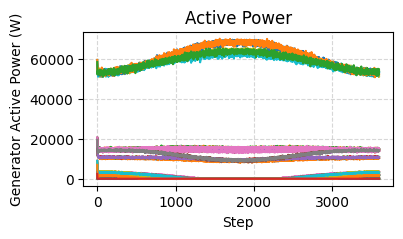

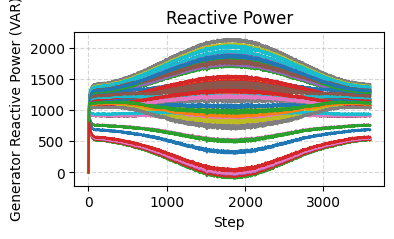

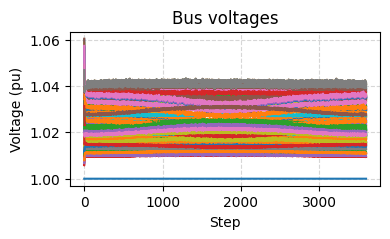

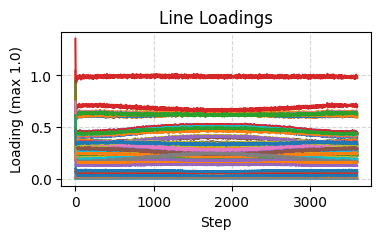

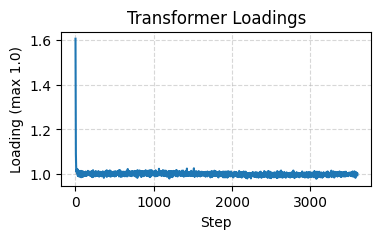

In [6]:
# 1️⃣ Generator Active Power (P)
plt.figure(figsize=(4, 2))
plt.plot(time, mat_p.T)
plt.title("Active Power")
plt.xlabel("Step")
plt.ylabel("Generator Active Power (W)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# 2️⃣ Generator Reactive Power (Q)
plt.figure(figsize=(4, 2))
plt.plot(time, mat_q.T)
plt.title("Reactive Power")
plt.xlabel("Step")
plt.ylabel("Generator Reactive Power (VAR)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# 3️⃣ Bus Voltages
plt.figure(figsize=(4, 2))
plt.plot(time, mat_v.T)
plt.title("Bus voltages")
plt.xlabel("Step")
plt.ylabel("Voltage (pu)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# 4️⃣ Line Loadings
plt.figure(figsize=(4, 2))
plt.plot(time, mat_line.T)
plt.title("Line Loadings")
plt.xlabel("Step")
plt.ylabel("Loading (max 1.0)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# 5️⃣ Transformer Loadings (if any)
if n_transformer >= 1:
    plt.figure(figsize=(4, 2))
    plt.plot(time, mat_transformer.T)
    plt.title("Transformer Loadings")
    plt.xlabel("Step")
    plt.ylabel("Loading (max 1.0)")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()
